<a href="https://colab.research.google.com/github/benisalla/BigMart-Data-Analysis-and-Prediction/blob/main/3SF_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Dataset to our local /content path

we will download the dataset of 'Oxford-IIIT for pets' (we are using pets dataset for the moments just because it is free and available to us but ofcourse the same logic and process will be applied on any dataset)

In [ ]:
# get the data from Oxford-IIIT to our local folder 'content'
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz  -P /content --no-check-certificate
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz  -P /content --no-check-certificate
%cd /content
# then we unzip the folders
!tar -C /content -xvf /content/images.tar.gz
!tar -C /content -xvf /content/annotations.tar.gz

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

# Importing packages

In [ ]:
import tensorflow as tf
import cv2

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from keras.utils import load_img, img_to_array


import tensorflow_datasets as tfds
from IPython.display import clear_output

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def read_and_preprocess(data):
    input_img = tf.image.resize(data['image'], (128,128)) #resizing
    input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))  #resizing

    # input_img = tf.image.convert_image_dtype(input_img, tf.float32) #converting image to 0,1 form
    # input_mask -=1 #shifting image categories from {1,2,3} to {0,1,2}
    return input_img , input_mask

In [ ]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls = tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
def agument(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask

train_dataset = train.cache().map(agument).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

--------------------------
--------------------------
--------------------------
--------------------------
--------------------------

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
#train split
X_train = train_batches.map(lambda x, y: x)
y_train = train_batches.map(lambda x, y: y)

#test split
X_test = test_batches.map(lambda x, y: x)
y_test = test_batches.map(lambda x, y: y)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

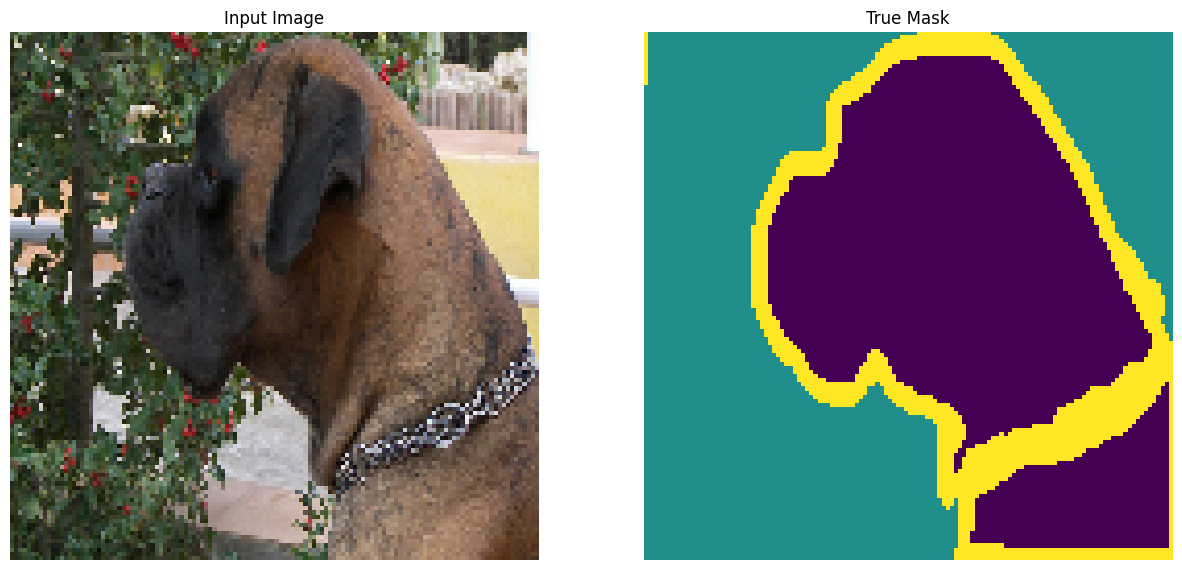

In [ ]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

---
---
---

In [ ]:
import skimage
import skimage.filters
import skimage.color
import random
from random import randint
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np

class AugmentBatch:

    def __init__(self):
        #random.seed(42)
        # Create a list of functions that could be applied on the batch
        self.__list_func = [lambda img: self.convert_to_gray(img), lambda img: self.add_noise(img),
                            lambda img: self.add_gaussian(img), lambda img: self.convert_to_sepia(img),
                            lambda img: self.color_swap(img), lambda img: self.invert_color(img)]

    def augment(self, batch):
        # Roll the dice
        prob = random.random()

        # Half chance of nothing half do some augmentation
        if prob < 0.5:
            return batch
        else:
            # Do a copy of the batch
            new_batch = batch

            # Flip steering independent of other augmentations (Idea is to have more steering actions on training)
            batch_fliped = self.flip_horizontal(new_batch)

            # Do augmentations based on the lambda list __list_func
            idx = 0
            for (img, label) in batch_fliped:
                # Choose one operation to be applied on each image of the batch
                operation = randint(0, len(self.__list_func) - 1)
                # Choose the operation randomically
                img = self.__list_func[operation](img)
                batch_fliped[idx] = (img, label)
                idx += 1

            return batch_fliped

    def convert_to_gray(self, img):
        # Get each channel
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        # To keep same number of channels add gray to each one.
        img[:, :, 0] = gray
        img[:, :, 1] = gray
        img[:, :, 2] = gray
        return img

    def convert_to_sepia(self, img):
        # Get each channel
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        # To keep same number of channels add gray to each one.
        img[:, :, 0] = 0.393 * r + 0.769 * g + 0.189 * b
        img[:, :, 1] = 0.349 * r + 0.686 * g + 0.168 * b
        img[:, :, 2] = 0.272 * r + 0.534 * g + 0.131 * b
        return img

    def add_noise(self, img):
        new_img = skimage.util.random_noise(img,var=0.001)
        return new_img

    def invert_color(self, img):
        new_img = skimage.util.invert(img)
        return new_img

    def add_gaussian(self, img):
        new_img = skimage.filters.gaussian(img,sigma=0.9, multichannel=True)
        return new_img

    def color_swap(self, img):
        new_img = img
        list_chanels = [0, 1, 2]
        random.shuffle(list_chanels)
        new_img[:, : ,0] = img[:, :, list_chanels[0]]
        new_img[:, :, 1] = img[:, :, list_chanels[1]]
        new_img[:, :, 2] = img[:, :, list_chanels[2]]
        return new_img

    # Flip both the image and the steering
    def flip_horizontal(self, batch):
        # Do a copy of the batch
        new_batch = batch
        idx = 0
        for (img, label) in new_batch:
            img = np.fliplr(img)
            label = np.fliplr(label)
            new_batch[idx] = (img, label)
            idx += 1
        return new_batch

    def display_batch(self, batch):
        for img, steering in batch:
            plt.imshow(img)
            plt.show()

In [ ]:
### encoder ###

'''Function to define the encoder structure'''
def build_encoder():
  Conv2D = functools.partial(tf.keras.layers.Conv2D, activation='relu', kernel_initializer='he_normal', padding='same')
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, strides=(2, 2), padding='same')
  Dropout = tf.keras.layers.Dropout
  MaxPooling2D = tf.keras.layers.MaxPooling2D

  model = tf.keras.Sequential([
    Conv2D(16, (3, 3)), Dropout(0.1), Conv2D(16, (3, 3)), MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3)), Dropout(0.1), Conv2D(32, (3, 3)), MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)), Dropout(0.2), Conv2D(64, (3, 3)), MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3)), Dropout(0.2), Conv2D(128, (3, 3)), MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3)), Dropout(0.2), Conv2D(128, (3, 3)), MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3)), Dropout(0.3), Conv2D(256, (3, 3)),

    Conv2DTranspose(128, (2, 2)), Conv2D(128, (3, 3)), Dropout(0.2), Conv2D(128, (3, 3))
  ])
  return model

In [ ]:
### decoder ###

'''Function to define the decoder structure'''
class build_decoder():
    def __init__(self, num_classes):
        self.Conv2D = functools.partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
        self.Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, kernel_size=(2, 2), strides=(2, 2), padding='same')

        self.num_classes = num_classes
        self.Conv2DTranspose_64 = self.Conv2DTranspose(filters=64)
        self.Conv2D_64 = self.Conv2D(filters=64)
        self.Add_1 = tf.keras.layers.Add()

        self.Conv2DTranspose_32 = self.Conv2DTranspose(filters=32)
        self.Conv2D_32 = self.Conv2D(filters=32)
        self.Add_2 = tf.keras.layers.Add()

        self.Conv2DTranspose_16_1 = self.Conv2DTranspose(filters=16)
        self.Conv2D_16_1 = self.Conv2D(filters=16)
        self.Add_3 = tf.keras.layers.Add()

        self.Conv2DTranspose_16_2 = self.Conv2DTranspose(filters=16)
        self.Conv2D_16_2 = self.Conv2D(filters=16)
        self.Add_4 = tf.keras.layers.Add()

        self.Conv2D_OutPut = self.Conv2D(filters=num_classes, kernel_size=(1, 1), activation='sigmoid')


    def call(self, inputs):
        x1 = self.Conv2DTranspose_64(inputs)
        x2 = self.Conv2D_64(x1)
        x3 = self.Add_1([x1, x2])

        x4 = self.Conv2DTranspose_32(x3)
        x5 = self.Conv2D_32(x4)
        x6 = self.Add_2([x4, x5])

        x7 = self.Conv2DTranspose_16_1(x6)
        x8 = self.Conv2D_16_1(x7)
        x9 = self.Add_3([x7, x8])

        x10 = self.Conv2DTranspose_16_2(x9)
        x11 = self.Conv2D_16_2(x10)
        x12 = self.Add_4([x10, x11])

        output = self.Conv2D_OutPut(x12)
        return output

In [ ]:
### encoder ###

'''Function to define the encoder structure'''
def encoder_function(input):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, activation='relu', kernel_initializer='he_normal', padding='same')
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, strides=(2, 2), padding='same')
  Dropout = tf.keras.layers.Dropout
  MaxPooling2D = tf.keras.layers.MaxPooling2D

  x1 = Conv2D(16, (3, 3))(input)
  x2 = Dropout(0.1)(x1)
  x3 = Conv2D(16, (3, 3))(x2)
  x4 = MaxPooling2D((2, 2))(x3)

  x5 = Conv2D(32, (3, 3))(x4)
  x6 = Dropout(0.1)(x5)
  x7 = Conv2D(32, (3, 3))(x6)
  x8 = MaxPooling2D((2, 2))(x7)

  x9 = Conv2D(64, (3, 3))(x8)
  x10 = Dropout(0.2)(x9)
  x11 = Conv2D(64, (3, 3))(x10)
  x12 = MaxPooling2D((2, 2))(x11)

  x13 = Conv2D(128, (3, 3))(x12)
  x14 = Dropout(0.2)(x13)
  x15 = Conv2D(128, (3, 3))(x14)
  x16 = MaxPooling2D((2, 2))(x15)

  x17 = Conv2D(128, (3, 3))(x16)
  x18 = Dropout(0.2)(x17)
  x19 = Conv2D(128, (3, 3))(x18)
  x20 = MaxPooling2D((2, 2))(x19)

  x21 = Conv2D(256, (3, 3))(x20)
  x22 = Dropout(0.3)(x21)
  x23 = Conv2D(256, (3, 3))(x22)

  x24 = Conv2DTranspose(128, (2, 2))(x23)
  x25 = Conv2D(128, (3, 3))(x24)
  x26 = Dropout(0.2)(x25)
  output = Conv2D(128, (3, 3))(x26)
  return output

In [ ]:
### decoder ###

'''Function to define the decoder structure'''
def decoder_function(input):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, kernel_size=(2, 2), strides=(2, 2), padding='same')

  x1 = Conv2DTranspose(64)(input)
  x2 = Conv2D(64)(x1)
  x3 = tf.keras.layers.Add()([x1, x2])

  x4 = Conv2DTranspose(32)(x3)
  x5 = Conv2D(32)(x4)
  x6 = tf.keras.layers.Add()([x4, x5])

  x7 = Conv2DTranspose(16)(x6)
  x8 = Conv2D(16)(x7)
  x9 = tf.keras.layers.Add()([x7, x8])

  x10 = Conv2DTranspose(16)(x9)
  x11 = Conv2D(16)(x10)
  x12 = tf.keras.layers.Add()([x10, x11])

  output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x12)
  return output

In [ ]:
#let's build the model
inputs = tf.keras.layers.Input(shape=(128, 128, 3))

encoder = encoder_function(inputs)
outputs = decoder_function(encoder)

FCNs = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
FCNs.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [187]:

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

steps_per_epoch = 10


FCNs.fit(train_batches,
         steps_per_epoch=steps_per_epoch,
         batch_size=16, epochs=10,
         callbacks=callbacks)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5633

10/10 [==============================] - 231s 7s/step - loss: 0.6878 - accuracy: 0.5633
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.5744

10/10 [==============================] - 71s 7s/step - loss: 0.6056 - accuracy: 0.5744
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.5918

10/10 [==============================] - 72s 7s/step - loss: 0.4174 - accuracy: 0.5918
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.6073

10/10 [==============================] - 73s 7s/step - loss: 0.2702 - accuracy: 0.6073
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: -892.6476 - accuracy: 0.6339  

10/10 [==============================] - 73s 7s/step - loss: -892.6476 - accuracy: 0.6339
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: -761536768.0000 - accuracy: 0.5887

10/10 [==============================] - 74s 7s/step - loss: -761536768.0000 - accuracy: 0.5887
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: -3347767623680.0000 - accuracy: 0.6004

10/10 [==============================] - 72s 7s/step - loss: -3347767623680.0000 - accuracy: 0.6004
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: -6862386002657280.0000 - accuracy: 0.5393

10/10 [==============================] - 73s 7s/step - loss: -6862386002657280.0000 - accuracy: 0.5393
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: -5309254128239640576.0000 - accuracy: 0.4981

10/10 [==============================] - 71s 7s/step - loss: -5309254128239640576.0000 - accuracy: 0.4981
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3401

10/10 [==============================] - 73s 7s/step - loss: nan - accuracy: 0.3401


In [ ]:
### now let's create  ###

class FCNs(tf.keras.Model):
  def __init__(self, num_classes):
    super(FCNs, self).__init__()
    self.num_classes = num_classes

    self.encoder = build_encoder()
    self.decoder = build_decoder(num_classes)

  # The call function on inputs x
  def call(self, x):
    decoder_output = self.decoder(self.encoder(x))
    return decoder_output

  @tf.function
  def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

  # Predict face or not face logit for given input x
  def predict(self, x):
    encoder_out = self.encoder(x)
    y_logit = self.decoder(encoder_out)
    return y_logit

  def fit(self, train_batches, num_epochs):
    cce_loss_func = tf.keras.losses.CategoricalCrossentropy()
    for i in range(num_epochs):
      IPython.display.clear_output(wait=True)
      print("Starting epoch {}/{}".format(i+1, num_epochs))

      # get a batch of training data and compute the training step
      for j, (X, true_y) in enumerate(train_batches):

        # print(y.shape)


        # # load a batch of data
        # tf.expand_dims(X, axis=-1)
        z = self.encoder(X)
        pred_y = self.decoder(z)
        # z = original_encoder(X)
        # print(f"z ==> {z.shape}")
        # print(f"pred_y ==> {pred_y.shape}")
        # print(f"true_y ==> {true_y.shape}")
        # print(pred_y.shape)
        # print("=====> after encoder")
        # pred_y = self.decoder(z)

        # # loss optimization
        # loss = cce_loss_func(pred_y, y)

        # # plot the progress every 200 steps
        # if j % 500 == 0:
        # print(loss)

        loss =  -tf.reduce_mean(true_y * tf.math.log(pred_y) + (1 - true_y) * tf.math.log(1 - pred_y))

        grads = tape.gradient(loss, standard_classifier.trainable_variables)
        optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))

        print("Loss:", loss.numpy())
        # break


fcns = FCNs(num_classes=1)
fcns.fit(train_batches, num_epochs=1)

In [ ]:
### Training The FCNs ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4


# number of epochs
num_epochs = 6

# FCNs instance
fcns = FCNs(num_classes=1)

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def fcns_train_step(x, y):

  with tf.GradientTape() as tape:
    logits = fcns(x)
    loss = -tf.reduce_mean(y * tf.math.log(logits) + (1 - y) * tf.math.log(1 - logits))
  grads = tape.gradient(loss, fcns.trainable_variables)
  optimizer.apply_gradients(zip(grads, fcns.trainable_variables))
  return loss


# clear if it exists
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

# The training loop over epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # loop over batchs
  for j, (x_batch, y_batch) in enumerate(train_batches):
    # loss optimization
    loss = fcns_train_step(x_batch, y_batch)

    print(loss.numpy())



KeyboardInterrupt: ignored

In [ ]:

# @tf.function
# def standard_train_step(self, x, y):
#   with tf.GradientTape() as tape:
#     z = self.encoder(X)
#     pred_y = self.decoder(z)
#     # Compute the loss
#     loss = -tf.reduce_mean(y * tf.math.log(pred_y) + (1 - y) * tf.math.log(1 - pred_y))
#   grads = tape.gradient(loss, standard_classifier.trainable_variables)
#   optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
#   return loss

NameError: ignored

In [ ]:
fcns = FCNs(num_classes=3)
fcns.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have a list of train_batches
train_batches = [batch for batch in train_dataset]  # Convert train_dataset to a list of batches

fcns.fit(train_batches, epochs=1)

In [ ]:
fcns.fit(train_batches, 5)

In [ ]:
### Training the SS-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
num_epochs = 6

# instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def ss_vae_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

    loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, ss_vae.trainable_variables)

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
  return loss


if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size)

    # loss optimization
    loss = ss_vae_train_step(x, y)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, ss_vae)

In [ ]:
import tensorflow as tf

# Assuming you have a train_dataset and test_dataset

batch_size = 32
num_epochs = 10

# Preprocess and batch the train_dataset
train_dataset = train_dataset.map(preprocess_function)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Preprocess and batch the test_dataset
test_dataset = test_dataset.map(preprocess_function)
test_dataset = test_dataset.batch(batch_size)

# Create and compile your model
model = FCNs()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the train_dataset
model.fit(train_dataset, epochs=num_epochs)

# Evaluate the model using the test_dataset
model.evaluate(test_dataset)
